# Quantitative Structure Property Relationship (QSPR) prediction of solubility

In this exercise, we will develop a QSPR model of solubility. 

When you are done with this exercise, save it under `Chem456-2022F/exercises` on Google Drive. It will be graded as satisfactory or unsatisfactory based on correctly completing the sections after `-->`. Do not remove the symbol `-->`.

# Part 0 - Set up Google Colab

In [1]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from io import StringIO

from rdkit import Chem
from rdkit.Chem import Descriptors

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

# Part 1 - Load data

We will use data from two sources. The first is the ESOL dataset (1), which includes low molecular weight organic compounds, medium-weight pesticide products and proprietary compounds from a pharmaceutical company. The second source is the Solubility challenge (2,3), in which the intrinsic solubility was measured for 100 drug-like compounds using an method that causes precipates to form and dissolve several times.

This exercise is based on the Solubility Challenge (2008). Data were downloaded from the [Goodman lab](https://www-jmg.ch.cam.ac.uk/data/solubility/).

(1) Delaney, J. S. ESOL: Estimating Aqueous Solubility Directly from Molecular Structure. J. Chem. Inf. Comput. Sci. 2004, 44 (3), 1000–1005. https://doi.org/10.1021/ci034243x.

(2) Llinàs, A.; Glen, R. C.; Goodman, J. M. Solubility Challenge: Can You Predict Solubilities of 32 Molecules Using a Database of 100 Reliable Measurements? J. Chem. Inf. Model. 2008, 48 (7), 1289–1303. https://doi.org/10.1021/ci800058v.

(3) Hewitt, M.; Cronin, M. T. D.; Enoch, S. J.; Madden, J. C.; Roberts, D. W.; Dearden, J. C. In Silico Prediction of Aqueous Solubility: The Solubility Challenge. J. Chem. Inf. Model. 2009, 49 (11), 2572–2587. https://doi.org/10.1021/ci900286s.


In [3]:
dat = {}
dat['Goodman_training'] = pd.read_csv(StringIO(r"""Substance,Temperature,assays,Ionic Strength (M),S0 (μM),SD of S0 (μM),Kinetic Solubility (μM),SD of Kinetic Solubility (μM),,,SMILES,InChI,
 1_naphthol,25.89,4,0.17121,10432.3,408.616,18026,11884,,,c1ccc2c(cccc2O)c1,"InChI=1/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/h1-7,11H",
 2_amino_5_bromobenzoic_acid,25,5,0.16295,842.692,14.6303,2562,863.3,,,Brc1cc(C(O)=O)c(N)cc1,"InChI=1/C7H6BrNO2/c8-4-1-2-6(9)5(3-4)7(10)11/h1-3H,9H2,(H,10,11)",
 4_iodophenol,25.74,4,0.218635,19312,604.678,25091,8427,,,c1cc(ccc1O)I,"InChI=1/C6H5IO/c7-5-1-3-6(8)4-2-5/h1-4,8H",
 5_bromo_2_4_dihydroxybenzoic_acid,25.05,5,0.186497,2397.22,40.1944,8726,753.8,,,Oc1c(Br)cc(C(O)=O)c(O)c1,"InChI=1/C7H5BrO4/c8-4-1-3(7(11)12)5(9)2-6(4)10/h1-2,9-10H,(H,11,12)",
 5_fluorouracil,25.1,,No precipitation detected. Kinetic solubility greater than 1180000 mM,,,,,,,Fc1c(=O)[nH]c(=O)[nH]c1,"InChI=1/C4H3FN2O2/c5-2-1-6-4(9)7-3(2)8/h1H,(H2,6,7,8,9)",
 acetaminophen,25.07,4,0.244024,86329.6,7016.34,161744,6983,,,O=C(Nc1ccc(cc1)O)C,"InChI=1/C8H9NO2/c1-6(10)9-7-2-4-8(11)5-3-7/h2-5,11H,1H3,(H,9,10)",
 acetazolamide,24.45,9,0.242023,3671.3,76.54,6098,3836,,,S(=O)(=O)(N)c1sc(NC(=O)C)nn1,"InChI=1/C4H6N4O3S2/c1-2(9)6-3-7-8-4(12-3)13(5,10)11/h1H3,(H2,5,10,11)(H,6,7,9)",
 alprenolol,25.59,2,0.160396,2321.89,41.6769,5079,46.81,,,CC(C)NCC(O)COc1ccccc1CC=C,"InChI=1/C15H23NO2/c1-4-7-13-8-5-6-9-15(13)18-11-14(17)10-16-12(2)3/h4-6,8-9,12,14,16-17H,1,7,10-11H2,2-3H3/t14-/m1/s1",
 amantadine,25.57,3,0.272664,14007.5,1181.13,17333,3954,,,C1C2CC3CC(CC1C3)(N)C2,"InChI=1/C10H17N/c11-10-4-7-1-8(5-10)3-9(2-7)6-10/h7-9H,1-6,11H2/t7-,8+,9-,10-",
 amiodarone,25.03,9,Co-solvent technique used. The resulting S0 at 0% MeOH is 0.0067 mM (Plot shown below),,,,,,,C(=O)(c1cc(c(c(I)c1)OCCN(CC)CC)I)c1c(oc2c1cccc2)CCCC,"InChI=1/C25H29I2NO3/c1-4-7-11-22-23(18-10-8-9-12-21(18)31-22)24(29)17-15-19(26)25(20(27)16-17)30-14-13-28(5-2)6-3/h8-10,12,15-16H,4-7,11,13-14H2,1-3H3",
 amitryptyline,25.13,3,0.156481,28.2093,2.89595,29.5,3.242,,,CN(C)CC\C=C1\c2ccccc2CCc2ccccc12,"InChI=1/C20H23N/c1-21(2)15-7-12-20-18-10-5-3-8-16(18)13-14-17-9-4-6-11-19(17)20/h3-6,8-12H,7,13-15H2,1-2H3",
 amodiaquine,25.56,7,0.168475,1.61562,0.436749,24.01,5.548,,,c1(c(CN(CC)CC)cc(cc1)Nc1ccnc2c1ccc(c2)Cl)O,"InChI=1/C20H22ClN3O/c1-3-24(4-2)13-14-11-16(6-8-20(14)25)23-18-9-10-22-19-12-15(21)5-7-17(18)19/h5-12,25H,3-4,13H2,1-2H3,(H,22,23)",
 aspirin,25.17,,"Ester hydrolysis occurred while the experiments were running, so no reliable solubility can be calculated",,,,,,,O=C(O)c1ccccc1OC(C)=O,"InChI=1/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)",
 atropine,24.66,5,0.199966,9942.05,459.867,12373,4388,,,CN1[C@H]2CC[C@@H]1C[C@@H](C2)OC(=O)C(CO)C1=CC=CC=C1,"InChI=1/C17H23NO3/c1-18-13-7-8-14(18)10-15(9-13)21-17(20)16(11-19)12-5-3-2-4-6-12/h2-6,13-16,19H,7-11H2,1H3/t13-,14+,15-,16-/m0/s1",
 azathioprine,24.89,5,0.159376,619.662,15.5596,6668,1600,,,S(c1n(cnc1N(=O)=O)C)c1ncnc2nc[nH]c12,"InChI=1/C9H7N7O2S/c1-15-4-14-7(16(17)18)9(15)19-8-5-6(11-2-10-5)12-3-13-8/h2-4H,1H3,(H,10,11,12,13)",
 benzylimidazole,25.03,4,0.257209,5524.32,1097.65,48472,8128,,,n1(Cc2ccccc2)cncc1,"InChI=1/C10H10N2/c1-2-4-10(5-3-1)8-12-7-6-11-9-12/h1-7,9H,8H2",
 bromogramine,25.05,3,0.151414,88.0647,6.30441,391.5,89.35,,,Brc1cc2c(CN(C)C)c[nH]c2cc1,"InChI=1/C11H13BrN2/c1-14(2)7-8-6-13-11-4-3-9(12)5-10(8)11/h3-6,13H,7H2,1-2H3",
 bupivacaine,25.13,2,0.190369,596.827,32.6167,1969,71.26,,,CCCCN1CCCCC1C(=O)Nc1c(C)cccc1C,"InChI=1/C18H28N2O/c1-4-5-12-20-13-7-6-11-16(20)18(21)19-17-14(2)9-8-10-15(17)3/h8-10,16H,4-7,11-13H2,1-3H3,(H,19,21)/t16-/m0/s1",
 carprofen,25.03,5,0.155863,20.0337,2.88887,49.58,12.93,,,CC(C(O)=O)c1ccc2c(c1)[nH]c1ccc(Cl)cc21,"InChI=1/C15H12ClNO2/c1-8(15(18)19)9-2-4-11-12-7-10(16)3-5-13(12)17-14(11)6-9/h2-8,17H,1H3,(H,18,19)/t8-/m0/s1",
 carvedilol,25.39,1,0.156213,55.5,-----------,63.3,----------,,,COc1ccccc1OCCNCC(O)COc1cccc2[nH]c3ccccc3c12,"InChI=1/C24H26N2O4/c1-28-21-10-4-5-11-22(21)29-14-13-25-15-17(27)16-30-23-12-6-9-20-24(23)18-7-2-3-8-19(18)26-20/h2-12,17,25-27H,13-16H2,1H3/t17-/m0/s1",
 cephalothin,25.66,2,0.206289,1153.54,2.50849,5624,608.2,,,C1(=C(COC(C)=O)CS[C@@H]2[C@H](NC(=O)Cc3cccs3)C(N12)=O)C(O)=O,"InChI=1/C16H16N2O6S2/c1-8(19)24-6-9-7-26-15-12(14(21)18(15)13(9)16(22)23)17-11(20)5-10-3-2-4-25-10/h2-4,12,15H,5-7H2,1H3,(H,17,20)(H,22,23)/t12-,15-/m1/s1",
 chlorpheniramine,24.94,2,0.191078,2154.31,149.751,2505,82.61,,,C([C@H](c1ccccn1)c1ccc(cc1)Cl)CN(C)C,"InChI=1/C16H19ClN2/c1-19(2)12-10-15(16-5-3-4-11-18-16)13-6-8-14(17)9-7-13/h3-9,11,15H,10,12H2,1-2H3/t15-/m0/s1",
 chlorpromazine,24.78,3,0.161714,8.50348,0.146398,8.885,0.8091,,,c1c(Cl)ccc2Sc3ccccc3N(CCCN(C)C)c12,"InChI=1/C17H19ClN2S/c1-19(2)10-5-11-20-14-6-3-4-7-16(14)21-17-9-8-13(18)12-15(17)20/h3-4,6-9,12H,5,10-11H2,1-2H3",
 chlorpropamide,24.94,4,0.156213,564.456,10.3631,1710,439.8,,,Clc1ccc(S(=O)(NC(=O)NCCC)=O)cc1,"InChI=1/C10H13ClN2O3S/c1-2-7-12-10(14)13-17(15,16)9-5-3-8(11)4-6-9/h3-6H,2,7H2,1H3,(H2,12,13,14)",
 chlorprothixene_form_I,25.48,9,0.153915,0.177964,0.00812546,1.554,0.1589,,,CN(C)CC\C=C1\c2ccccc2Sc2ccc(cc12)Cl,"InChI=1/C18H18ClNS/c1-20(2)11-5-7-14-15-6-3-4-8-17(15)21-18-10-9-13(19)12-16(14)18/h3-4,6-10,12H,5,11H2,1-2H3/b14-7-",
 chlorprothixene_form_II,26.11,9,0.153385,1.36105,0.12461,1.562,0.1519,,,CN(C)CC\C=C1\c2ccccc2Sc2ccc(cc12)Cl,"InChI=1/C18H18ClNS/c1-20(2)11-5-7-14-15-6-3-4-8-17(15)21-18-10-9-13(19)12-16(14)18/h3-4,6-10,12H,5,11H2,1-2H3/b14-7-",
 chlorzoxazone,25.11,9,0.17089,2205.23,382.491,5210,1821,,,c1cc2c(cc1Cl)[nH]c(=O)o2,"InChI=1/C7H4ClNO2/c8-4-1-2-6-5(3-4)9-7(10)11-6/h1-3H,(H,9,10)",
 cimetidine,24.74,5,0.209947,20340.2,483.526,86342,2445,,,Cc1c(nc[nH]1)CSCCN\C(=N\C)NC#N,"InChI=1/C10H16N6S/c1-8-9(16-7-15-8)5-17-4-3-13-10(12-2)14-6-11/h7H,3-5H2,1-2H3,(H,15,16)(H2,12,13,14)",
 ciprofloxacin,24.97,3,0.174278,253.219,27.0349,2226,1237,,,O=C(c1cn(C2CC2)c2c(cc(F)c(N3CCNCC3)c2)c1=O)O,"InChI=1/C17H18FN3O3/c18-13-7-11-14(8-15(13)20-5-3-19-4-6-20)21(10-1-2-10)9-12(16(11)22)17(23)24/h7-10,19H,1-6H2,(H,23,24)",
 danofloxacin,25.11,1,0.177023,1260,-----------,1935,-----------,,,C[N@]1C[C@@H]2C[C@H]1CN2c1c(cc2c(n(cc(C(=O)O)c2=O)C2CC2)c1)F,"InChI=1/C19H20FN3O3/c1-21-7-12-4-11(21)8-22(12)17-6-16-13(5-15(17)20)18(24)14(19(25)26)9-23(16)10-2-3-10/h5-6,9-12H,2-4,7-8H2,1H3,(H,25,26)/t11-,12-/m0/s1",
 deprenyl,25.1,4,0.1686,3072.66,128.473,3207,99.55,,,C[C@H](CC1=CC=CC=C1)N(C)CC#C,"InChI=1/C13H17N/c1-4-10-14(3)12(2)11-13-8-6-5-7-9-13/h1,5-9,12H,10-11H2,2-3H3/t12-/m1/s1",
 desipramine,25.14,3,0.157332,235.682,8.24164,255.2,4.995,,,N1(c2c(CCc3ccccc13)cccc2)CCCNC,"InChI=1/C18H22N2/c1-19-13-6-14-20-17-9-4-2-7-15(17)11-12-16-8-3-5-10-18(16)20/h2-5,7-10,19H,6,11-14H2,1H3",
 diazoxide,24.85,4,0.171087,434.438,23.2077,2289,428.8,,,Clc1cc2S(=O)(=O)N=C(Nc2cc1)C,"InChI=1/C8H7ClN2O2S/c1-5-10-7-3-2-6(9)4-8(7)14(12,13)11-5/h2-4H,1H3,(H,10,11)",
 diclofenac,25.08,21,0.158862,3.49648,0.0608494,148.4,40.36,,,c1(c(Nc2c(cccc2Cl)Cl)cccc1)CC(=O)O,"InChI=1/C14H11Cl2NO2/c15-10-5-3-6-11(16)14(10)17-12-7-2-1-4-9(12)8-13(18)19/h1-7,17H,8H2,(H,18,19)",
 difloxacin,24.79,2,0.184326,251.311,1.96352,820,9.745,,,CN1CCN(CC1)c1c(cc2c(n(cc(C(=O)O)c2=O)c2ccc(cc2)F)c1)F,"InChI=1/C21H19F2N3O3/c1-24-6-8-25(9-7-24)19-11-18-15(10-17(19)23)20(27)16(21(28)29)12-26(18)14-4-2-13(22)3-5-14/h2-5,10-12H,6-9H2,1H3,(H,28,29)",
 diltiazem,26.16,2,0.152174,693.647,44.9338,881.6,50.39,,,O=C1[C@H](OC(C)=O)[C@H](c2ccc(OC)cc2)Sc2ccccc2N1CCN(C)C,"InChI=1/C22H26N2O4S/c1-15(25)28-20-21(16-9-11-17(27-4)12-10-16)29-19-8-6-5-7-18(19)24(22(20)26)14-13-23(2)3/h5-12,20-21H,13-14H2,1-4H3/t20-,21+/m1/s1",
 diphenydramine,25.79,2,0.157371,1133.31,28.3267,1241,128,,,CN(C)CCOC(c1ccccc1)c1ccccc1,"InChI=1/C17H21NO/c1-18(2)13-14-19-17(15-9-5-3-6-10-15)16-11-7-4-8-12-16/h3-12,17H,13-14H2,1-2H3",
 diphenylhydantoin,24.89,7,0.173428,139.293,15.6883,477.2,234,,,O=C1NC(=O)NC1(c1ccccc1)c1ccccc1,"InChI=1/C15H12N2O2/c18-13-15(17-14(19)16-13,11-7-3-1-4-8-11)12-9-5-2-6-10-12/h1-10H,(H2,16,17,18,19)",
 enrofloxacin,25.1,7,0.196334,659.005,81.8201,5054,1122,,,CCN1CCN(CC1)c1c(cc2c(n(cc(C(=O)O)c2=O)C2CC2)c1)F,"InChI=1/C19H22FN3O3/c1-2-21-5-7-22(8-6-21)17-10-16-13(9-15(17)20)18(24)14(19(25)26)11-23(16)12-3-4-12/h9-12H,2-8H2,1H3,(H,25,26)",
 famotidine,25.01,2,0.169198,2255.02,47.4681,18007,1253,,,N\C(CCSCc1csc(\N=C(\N)N)n1)=N\S(=O)(N)=O,"InChI=1/C8H17N7O2RnS2/c9-6(15-18(12,16)17)1-2-19-3-5-4-20-8(13-5)14-7(10)11/h4,16-17H,1-3,12H2,(H2,9,15)(H4,10,11,13,14)",
 fenoprofen,24.91,10,0.161863,200.349,30.3899,270.1,28.37,,,CC(C(O)=O)c1cccc(Oc2ccccc2)c1,"InChI=1/C15H14O3/c1-11(15(16)17)12-6-5-9-14(10-12)18-13-7-3-2-4-8-13/h2-11H,1H3,(H,16,17)/t11-/m0/s1",
 flufenamic_acid,25.77,2,0.15871,4.41611,0.0773372,45.22,0.6388,,,C(c1c(Nc2cc(ccc2)C(F)(F)F)cccc1)(=O)O,"InChI=1/C14H10F3NO2/c15-14(16,17)9-4-3-5-10(8-9)18-12-7-2-1-6-11(12)13(19)20/h1-8,18H,(H,19,20)",
 flumequine,24.9,5,0.154888,185.101,12.488,675.9,106.5,,,CC1CCc2cc(F)cc3c2n1cc(C(O)=O)c3=O,"InChI=1/C14H12FNO3/c1-7-2-3-8-4-9(15)5-10-12(8)16(7)6-11(13(10)17)14(18)19/h4-7H,2-3H2,1H3,(H,18,19)/t7-/m1/s1",
 flurbiprofen,25.76,2,0.158737,70.5019,0.364231,207.2,132.7,,,CC(C(O)=O)c1ccc(c(F)c1)-c1ccccc1,"InChI=1/C15H13FO2/c1-10(15(17)18)12-7-8-13(14(16)9-12)11-5-3-2-4-6-11/h2-10H,1H3,(H,17,18)/t10-/m0/s1",
 glipizide,25.11,7,0.156918,3.2497,0.0910179,94.07,64.09,,,O=C(NC1CCCCC1)NS(=O)(c1ccc(CCNC(c2cnc(cn2)C)=O)cc1)=O,"InChI=1/C21H29N5O4Rn/c1-15-13-24-19(14-23-15)20(27)22-12-11-16-7-9-18(10-8-16)31(29,30)26-21(28)25-17-5-3-2-4-6-17/h7-10,13-14,17,29-30H,2-6,11-12H2,1H3,(H,22,27)(H2,25,26,28)",
 guanine,24.88,10,0.16507,37.382,8.95298,673.1,204.3,,,[nH]1cnc2nc(N)[nH]c(=O)c12,"InChI=1/C5H5N5O/c6-5-9-3-2(4(11)10-5)7-1-8-3/h1H,(H4,6,7,8,9,10,11)",
 hexobarbital,24.89,8,0.183136,2122.94,108.811,5982,1062,,,CN1C(=O)NC(=O)C(C)(C1=O)C1=CCCCC1,"InChI=1/C12H16N2O3/c1-12(8-6-4-3-5-7-8)9(15)13-11(17)14(2)10(12)16/h6H,3-5,7H2,1-2H3,(H,13,15,17)/t12-/m1/s1",
 hydroflumethiazide,24.85,9,0.181974,1080.1,301.671,8333,5221,,,S1(=O)(=O)NCNc2c1cc(S(=O)(N)=O)c(c2)C(F)(F)F,"InChI=1/C8H8F3N3O4S2/c9-8(10,11)4-1-5-7(2-6(4)19(12,15)16)20(17,18)14-3-13-5/h1-2,13-14H,3H2,(H2,12,15,16)",
 5_hydroxybenzoic_acid,25.38,2,0.21772,34323.2,672.523,52775,1554,,,C(c1ccc(cc1)O)(=O)O,"InChI=1/C7H6O3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H,(H,9,10)",
 ibuprofen,24.94,16,0.161012,254.455,15.832,947.5,58.79,,,CC(C)Cc1ccc(cc1)C(C)C(O)=O,"InChI=1/C13H18O2/c1-9(2)8-11-4-6-12(7-5-11)10(3)13(14)15/h4-7,9-10H,8H2,1-3H3,(H,14,15)/t10-/m0/s1",
 levofloxacin,25.09,,No precipitation detected. Kinetic solubility greater than 140000 mM,,,,,,,O=C(c1cn2[C@@H](C)COc3c(N4CCN(C)CC4)c(F)cc(c1=O)c23)O,"InChI=1/C18H20FN3O4/c1-10-9-26-17-14-11(16(23)12(18(24)25)8-22(10)14)7-13(19)15(17)21-5-3-20(2)4-6-21/h7-8,10H,3-6,9H2,1-2H3,(H,24,25)/t10-/m0/s1",
 lomefloxacin,25.18,1,0.234,4647,-----------,55550,-----------,,,CCn1cc(C(O)=O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c12,"InChI=1/C17H19F2N3O3/c1-3-21-8-11(17(24)25)16(23)10-6-12(18)15(13(19)14(10)21)22-5-4-20-9(2)7-22/h6,8-9,20H,3-5,7H2,1-2H3,(H,24,25)/t9-/m0/s1",
 loperamide,24.88,10,Co-solvent technique used. The resulting S0 at 0% MeOH is 0.08427 mM (Plot shown below),,,,,,,CN(C)C(=O)C(CCN1CCC(CC1)(c1ccc(cc1)Cl)O)(c1ccccc1)c1ccccc1,"InChI=1/C29H33ClN2O2/c1-31(2)27(33)29(24-9-5-3-6-10-24,25-11-7-4-8-12-25)19-22-32-20-17-28(34,18-21-32)23-13-15-26(30)16-14-23/h3-16,34H,17-22H2,1-2H3",
 l-proline,24.95,,No precipitation detected. Kinetic solubility greater than 535000 mM,,,,,,,C([C@H]1NCCC1)(=O)O,"InChI=1/C5H9NO2/c7-5(8)4-2-1-3-6-4/h4,6H,1-3H2,(H,7,8)/t4-/m0/s1",
 maprotiline,25.03,2,0.15616,20.3495,0.871933,747,585.4,,,N(C)CCCC12c3c(C(c4ccccc14)CC2)cccc3,"InChI=1/C20H23N/c1-21-14-6-12-20-13-11-15(16-7-2-4-9-18(16)20)17-8-3-5-10-19(17)20/h2-5,7-10,15,21H,6,11-14H2,1H3/t15-,20+",
 meclizine,24.37,7,Co-solvent technique used. The resulting S0 at 0% MDM is 0.322 mM (Plot shown below),,,,,,,Cc1cccc(CN2CCN(CC2)C(c2ccccc2)c2ccc(Cl)cc2)c1,"InChI=1/C25H27ClN2/c1-20-6-5-7-21(18-20)19-27-14-16-28(17-15-27)25(22-8-3-2-4-9-22)23-10-12-24(26)13-11-23/h2-13,18,25H,14-17,19H2,1H3/t25-/m0/s1",
 mefenamic_acid,25.11,2,0.1536,0.183299,0.00119501,0.5959,0.07178,,,C(c1c(Nc2c(c(ccc2)C)C)cccc1)(=O)O,"InChI=1/C15H15NO2/c1-10-6-5-9-13(11(10)2)16-14-8-4-3-7-12(14)15(17)18/h3-9,16H,1-2H3,(H,17,18)",
 metoclopramide,24.58,9,0.15717,271.981,15.6341,1193,282.2,,,CCN(CC)CCNC(=O)c1cc(c(cc1OC)N)Cl,"InChI=1/C14H22ClN3O2/c1-4-18(5-2)7-6-17-14(19)10-8-11(15)12(16)9-13(10)20-3/h8-9H,4-7,16H2,1-3H3,(H,17,19)",
 metronidazole,24.94,5,0.213369,60058.7,1521.74,92832,7930,,,OCCn1c(ncc1N(=O)=O)C,"InChI=1/C6H9N3O3/c1-5-7-4-6(9(11)12)8(5)2-3-10/h4,10H,2-3H2,1H3",
 miconazole,24.79,5,0.151898,8.53676,0.316198,27.14,11.67,,,Clc1ccc(COC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1,"InChI=1/C18H14Cl4N2O/c19-13-2-1-12(16(21)7-13)10-25-18(9-24-6-5-23-11-24)15-4-3-14(20)8-17(15)22/h1-8,11,18H,9-10H2/t18-/m1/s1",
 nalidixic_acid,24.94,5,0.152515,245.393,5.30714,526.1,76.64,,,CCn1cc(c(=O)c2ccc(nc12)C)C(=O)O,"InChI=1/C12H12N2O3/c1-3-14-6-9(12(16)17)10(15)8-5-4-7(2)13-11(8)14/h4-6H,3H2,1-2H3,(H,16,17)",
 naloxone,24.63,5,0.185465,1265.36,89.5956,6366,653.1,,,O[C@]1([C@H](N(CC=C)CC2)C3)[C@@]42C5=C3C=CC(O)=C5O[C@H]4C(CC1)=O,"InChI=1/C19H21NO4/c1-2-8-20-9-7-18-15-11-3-4-12(21)16(15)24-17(18)13(22)5-6-19(18,23)14(20)10-11/h2-4,14,17,21,23H,1,5-10H2/t14-,17+,18+,19-/m1/s1",
 naproxen,25.13,3,0.158009,31.9125,0.474116,85.56,14.44,,,O=C(O)[C@@H](C)c1ccc2cc(ccc2c1)OC,"InChI=1/C14H14O3/c1-9(14(15)16)10-3-4-12-8-13(17-2)6-5-11(12)7-10/h3-9H,1-2H3,(H,15,16)/t9-/m0/s1",
 niflumic_acid,25.08,5,0.153651,26.3681,5.48824,159.3,68.23,,,C(c1cccnc1Nc1cc(ccc1)C(F)(F)F)(=O)O,"InChI=1/C13H9F3N2O2/c14-13(15,16)8-3-1-4-9(7-8)18-11-10(12(19)20)5-2-6-17-11/h1-7H,(H,17,18)(H,19,20)",
 nitrofurantoin,24.77,6,0.163069,577.432,27.3512,1655,486.5,,,O=C1NC(CN1\N=C\c1ccc(N(=O)=O)o1)=O,"InChI=1/C8H6N4O5/c13-6-4-11(8(14)10-6)9-3-5-1-2-7(17-5)12(15)16/h1-3H,4H2,(H,10,13,14)/b9-3-",
 norfloxacin,25.17,1,0.222035,1752,-----------,10640,-----------,,,CCn1cc(c(=O)c2cc(c(cc12)N1CCNCC1)F)C(=O)O,"InChI=1/C16H18FN3O3/c1-2-19-9-11(16(22)23)15(21)10-7-12(17)14(8-13(10)19)20-5-3-18-4-6-20/h7-9,18H,2-6H2,1H3,(H,22,23)",
 nortriptiline,24.92,3,0.154624,96.1989,4.82375,101.7,1.929,,,N(CC\C=C1\c2c(CCc3c1cccc3)cccc2)C,"InChI=1/C19H21N/c1-20-14-6-11-19-17-9-4-2-7-15(17)12-13-16-8-3-5-10-18(16)19/h2-5,7-11,20H,6,12-14H2,1H3",
 ofloxacin,25.17,3,0.208864,54262.5,560,80000,10000,,,CC1COc2c(N3CCN(C)CC3)c(F)cc3c2n1cc(C(O)=O)c3=O,"InChI=1/C18H20FN3O4/c1-10-9-26-17-14-11(16(23)12(18(24)25)8-22(10)14)7-13(19)15(17)21-5-3-20(2)4-6-21/h7-8,10H,3-6,9H2,1-2H3,(H,24,25)/t10-/m1/s1",
 orbifloxacin,25.09,,No precipitation detected. Kinetic solubility greater than 26800 mM,,,,,,,C[C@H]1CN(C[C@@H](C)N1)c1c(F)c(F)c2c(c1F)n(cc(C(O)=O)c2=O)C1CC1,"InChI=1/C19H20F3N3O3/c1-8-5-24(6-9(2)23-8)17-14(21)13(20)12-16(15(17)22)25(10-3-4-10)7-11(18(12)26)19(27)28/h7-10,23H,3-6H2,1-2H3,(H,27,28)/t8-,9+",
 oxytetracycline,25.06,3,0.193238,816.361,175.686,19770,2543,,,OC1=C(C(O)=C(C([C@@](C(C(C(N)=O)=C(O)[C@H]2N(C)C)=O)(O)[C@@]2([H])[C@H]3O)=O)[C@@]3([H])[C@@]4(O)C)C4=CC=C1,"InChI=1/C22H24N2O9/c1-21(32)7-5-4-6-8(25)9(7)15(26)10-12(21)17(28)13-14(24(2)3)16(27)11(20(23)31)19(30)22(13,33)18(10)29/h4-6,12-14,17,25,27-29,32-33H,1-3H3,(H2,23,31)/t12-,13-,14+,17+,21-,22-/m1/s1",
 papaverine,25.19,6,0.157911,135.773,11.9886,2553,225.7,,,c1(nccc2cc(c(OC)cc12)OC)Cc1cc(c(cc1)OC)OC,"InChI=1/C20H21NO4/c1-22-17-6-5-13(10-18(17)23-2)9-16-15-12-20(25-4)19(24-3)11-14(15)7-8-21-16/h5-8,10-12H,9H2,1-4H3",
 penG (benzylpenicillin),24.93,,"b-lactam  hydrolysis occurred while the experiments were running, so no reliable solubility can be calculated",,,,,,,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(O)=O,"InChI=1/C16H18N2O4S/c1-16(2)12(15(21)22)18-13(20)11(14(18)23-16)17-10(19)8-9-6-4-3-5-7-9/h3-7,11-12,14H,8H2,1-2H3,(H,17,19)(H,21,22)/t11-,12-,14+/m0/s1",
 phenantroline,25.02,1,0.28,24100,-----------,112000,-----------,,,c12c(ccc3cccnc13)cccn2,InChI=1/C12H8N2/c1-3-9-5-6-10-4-2-8-14-12(10)11(9)13-7-1/h1-8H,
 phenazopyridine,24.9,5,0.155577,64.0651,2.42546,400,70,,,c1ccc(cc1)\N=N\c1c(nc(cc1)N)N,"InChI=1/C11H11N5/c12-10-7-6-9(11(13)14-10)16-15-8-4-2-1-3-5-8/h1-7H,(H4,12,13,14)/b16-15+",
 phenobarbital,25.04,9,0.191433,5087.23,275.762,10274,2455,,,C1(NC(C(c2ccccc2)(C(=O)N1)CC)=O)=O,"InChI=1/C12H12N2O3/c1-2-12(8-6-4-3-5-7-8)9(15)13-11(17)14-10(12)16/h3-7H,2H2,1H3,(H2,13,14,15,16,17)",
 phenylbutazone,26.16,2,0.152777,40.6647,0.0441385,161.6,7.403,,,N1(N(c2ccccc2)C(C(CCCC)C1=O)=O)c1ccccc1,"InChI=1/C19H20N2O2/c1-2-3-14-17-18(22)20(15-10-6-4-7-11-15)21(19(17)23)16-12-8-5-9-13-16/h4-13,17H,2-3,14H2,1H3",
 phthalic_acid_form_I,25.1,7,0.280791,32158.4,2311.89,52659,17955,,,C(c1c(C(=O)O)cccc1)(=O)O,"InChI=1/C8H6O4/c9-7(10)5-3-1-2-4-6(5)8(11)12/h1-4H,(H,9,10)(H,11,12)",
 phthalic_acid_form_II,24.86,7,0.261149,24823.5,864.304,52659,17955,,,C(c1c(C(=O)O)cccc1)(=O)O,"InChI=1/C8H6O4/c9-7(10)5-3-1-2-4-6(5)8(11)12/h1-4H,(H,9,10)(H,11,12)",
 pindolol,25.58,2,0.160697,162.89,3.87,1933,1296,,,CC(C)NCC(O)COc1cccc2[nH]ccc12,"InChI=1/C14H20N2O2/c1-10(2)16-8-11(17)9-18-14-5-3-4-13-12(14)6-7-15-13/h3-7,10-11,15-17H,8-9H2,1-2H3/t11-/m1/s1",
 piroxicam,25.03,3,0.15347,15.7828,0.545686,590.5,109.3,,,S1(=O)(=O)N(C)C(=C(c2ccccc12)O)C(Nc1ccccn1)=O,"InChI=1/C15H15N3O4Rn/c1-18-13(15(20)17-12-8-4-5-9-16-12)14(19)10-6-2-3-7-11(10)23(18,21)22/h2-9,19,21-22H,1H3,(H,16,17,20)",
 procainamide,24.87,,No precipitation detected. Kinetic solubility greater than 43800 mM,,,,,,,Nc1ccc(C(NCCN(CC)CC)=O)cc1,"InChI=1/C13H21N3O/c1-3-16(4-2)10-9-15-13(17)11-5-7-12(14)8-6-11/h5-8H,3-4,9-10,14H2,1-2H3,(H,15,17)",
 procaine,25.19,3,0.192001,19094,820.572,19787,410.1,,,Nc1ccc(C(OCCN(CC)CC)=O)cc1,"InChI=1/C13H20N2O2/c1-3-15(4-2)9-10-17-13(16)11-5-7-12(14)8-6-11/h5-8H,3-4,9-10,14H2,1-2H3",
 propranolol,25.52,3,0.160033,320.772,16.0016,1127,268.6,,,CC(C)NCC(O)COc1cccc2ccccc12,"InChI=1/C16H21NO2/c1-12(2)17-10-14(18)11-19-16-9-5-7-13-6-3-4-8-15(13)16/h3-9,12,14,17-18H,10-11H2,1-2H3/t14-/m1/s1",
 quinine,24.98,2,0.164556,1635.1,36.3736,1446,85.92,,,[H]C1(CN2CCC1C[C@@]2([H])[C@H](O)C1=CC=NC2=C1C=C(OC)C=C2)C=C,"InChI=1/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10-19(22)20(23)16-6-8-21-18-5-4-15(24-2)11-17(16)18/h3-6,8,11,13-14,19-20,23H,1,7,9-10,12H2,2H3/t13-,14-,19-,20+/m1/s1",
 ranitidine,24.99,2,0.218043,3156.04,502.563,52200,0,,,S(Cc1oc(CN(C)C)cc1)CCN\C(NC)=C\N(=O)=O,"InChI=1/C13H22N4O3S/c1-14-13(9-17(18)19)15-6-7-21-10-12-5-4-11(20-12)8-16(2)3/h4-5,9,14-15H,6-8,10H2,1-3H3/b13-9+",
 sarafloxacin,24.84,2,0.182198,735.587,59.0626,2051,208.2,,,C1CN(CCN1)c1c(cc2c(n(cc(C(=O)O)c2=O)c2ccc(cc2)F)c1)F,"InChI=1/C20H17F2N3O3/c21-12-1-3-13(4-2-12)25-11-15(20(27)28)19(26)14-9-16(22)18(10-17(14)25)24-7-5-23-6-8-24/h1-4,9-11,23H,5-8H2,(H,27,28)",
 sertraline,24.94,,Co-solvent technique used. The resulting S0 at 0% MeOH is 14.8 mM (Plot shown below),,,,,,,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc12,"InChI=1/C17H17Cl2N/c1-20-17-9-7-12(13-4-2-3-5-14(13)17)11-6-8-15(18)16(19)10-11/h2-6,8,10,12,17,20H,7,9H2,1H3/t12-,17-/m1/s1",
 sparfloxacin,25.11,3,0.185745,425.472,34.7113,14199,1726,,,C[C@H]1CN(C[C@@H](C)N1)C1=C(F)C2=C(C(=O)C(=CN2C2CC2)C(O)=O)C(N)=C1F,"InChI=1/C19H22F2N4O3/c1-8-5-24(6-9(2)23-8)17-13(20)15(22)12-16(14(17)21)25(10-3-4-10)7-11(18(12)26)19(27)28/h7-10,23H,3-6,22H2,1-2H3,(H,27,28)/t8-,9+",
 sulfacetamide,25.02,8,0.210577,30204,240.063,46582,6670,,,C(=O)(NS(=O)(c1ccc(cc1)N)=O)C,"InChI=1/C8H12N2O3Rn/c1-6(11)10-14(12,13)8-4-2-7(9)3-5-8/h2-5,12-13H,9H2,1H3,(H,10,11)",
 sulfamethazine,25.15,5,0.166127,1851.55,23.1153,23727,10516,,,S(=O)(=O)(Nc1nc(C)cc(n1)C)c1ccc(N)cc1,"InChI=1/C12H14N4O2S/c1-8-7-9(2)15-12(14-8)16-19(17,18)11-5-3-10(13)4-6-11/h3-7H,13H2,1-2H3,(H,14,15,16)",
 sulfasalazine,24.69,8,0.162673,0.726312,0.0419115,34.22,2.35,,,C(=O)(O)c1cc(ccc1O)\N=N\c1ccc(cc1)S(=O)(Nc1ccccn1)=O,"InChI=1/C18H16N4O5Rn/c23-16-9-6-13(11-15(16)18(24)25)21-20-12-4-7-14(8-5-12)28(26,27)22-17-3-1-2-10-19-17/h1-11,23,26-27H,(H,19,22)(H,24,25)/b21-20+",
 sulfathiazole,25.59,2,0.198869,2045.72,176.579,2400,477.3,,,Nc1ccc(cc1)S(=O)(Nc1nccs1)=O,"InChI=1/C9H11N3O2RnS/c10-7-1-3-8(4-2-7)15(13,14)12-9-11-5-6-16-9/h1-6,13-14H,10H2,(H,11,12)",
 sulindac_form_I,24.84,20,0.160486,210.015,23.1367,231.5,26.48,,,CC1=C(CC(O)=O)c2cc(F)ccc2C\1=C\c1ccc(cc1)S(C)=O,"InChI=1/C20H17FO3S/c1-12-17(9-13-3-6-15(7-4-13)25(2)24)16-8-5-14(21)10-19(16)18(12)11-20(22)23/h3-10H,11H2,1-2H3,(H,22,23)/b17-9-/t25-/m1/s1",
 sulindac_form_II,24.83,19,0.15972,31.9025,4.12412,234.7,29.93,,,CC1=C(CC(O)=O)c2cc(F)ccc2C\1=C\c1ccc(cc1)S(C)=O,"InChI=1/C20H17FO3S/c1-12-17(9-13-3-6-15(7-4-13)25(2)24)16-8-5-14(21)10-19(16)18(12)11-20(22)23/h3-10H,11H2,1-2H3,(H,22,23)/b17-9-/t25-/m1/s1",
 tetracaine,25.93,2,0.158034,975.128,21.571,1071,24.36,,,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,"InChI=1/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9-14)15(18)19-12-11-17(2)3/h6-9,16H,4-5,10-12H2,1-3H3",
 tetracycline,25.08,8,0.188221,1185.68,190.247,25389,7714,,,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C)C)=O)(O)[C@@]3([H])C[C@]2([H])[C@@]4(O)C)=O)C4=CC=C1,"InChI=1/C22H24N2O8/c1-21(31)8-5-4-6-11(25)12(8)16(26)13-9(21)7-10-15(24(2)3)17(27)14(20(23)30)19(29)22(10,32)18(13)28/h4-6,9-10,15,25-26,30-32H,7,23H2,1-3H3/b20-14-/t9-,10-,15-,21+,22-/m0/s1",
 thymol,24.98,3,0.173398,6520.2,38.3495,9000,141,,,c1(cc(ccc1C(C)C)C)O,"InChI=1/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4-7,11H,1-3H3",
 tolmetin,24.97,12,0.158806,80.9303,4.00252,395.3,94.64,,,Cc1ccc(cc1)C(=O)c1ccc(CC(=O)O)n1C,"InChI=1/C15H15NO3/c1-10-3-5-11(6-4-10)15(19)13-8-7-12(16(13)2)9-14(17)18/h3-8H,9H2,1-2H3,(H,17,18)",
 trichloromethiazide_form_I,25.66,3,0.163679,660.645,17.5235,4530,2054,,,NS(=O)(=O)c1cc2c(NC(NS2(=O)=O)C(Cl)Cl)cc1Cl,"InChI=1/C8H12Cl3N3O4Rn2/c9-3-1-4-6(2-5(3)19(12,15)16)20(17,18)14-8(13-4)7(10)11/h1-2,7-8,13-18H,12H2/t8-/m0/s1",
 trichloromethiazide_form_II,25.67,3,0.16193,295.843,0,4530,2054,,,NS(=O)(=O)c1cc2c(NC(NS2(=O)=O)C(Cl)Cl)cc1Cl,"InChI=1/C8H12Cl3N3O4Rn2/c9-3-1-4-6(2-5(3)19(12,15)16)20(17,18)14-8(13-4)7(10)11/h1-2,7-8,13-18H,12H2/t8-/m0/s1",
 trimethoprim,25.02,6,0.162422,1119.25,96.4116,5841,2175,,,c1(nc(c(cn1)Cc1cc(c(c(OC)c1)OC)OC)N)N,"InChI=1/C14H18N4O3/c1-19-10-5-8(6-11(20-2)12(10)21-3)4-9-7-17-14(16)18-13(9)15/h5-7H,4H2,1-3H3,(H4,15,16,17,18)",
 trimipramine,25.14,3,0.163942,16.2552,2.99725,17.3,2.136,,,CC(CN(C)C)CN1c2ccccc2CCc2ccccc12,"InChI=1/C20H26N2/c1-16(14-21(2)3)15-22-19-10-6-4-8-17(19)12-13-18-9-5-7-11-20(18)22/h4-11,16H,12-15H2,1-3H3/t16-/m1/s1",
 tryptamine,25.42,3,0.241194,506.279,134.019,20650,6415,,,NCCc1c[nH]c2ccccc12,"InChI=1/C10H12N2/c11-6-5-8-7-12-10-4-2-1-3-9(8)10/h1-4,7,12H,5-6,11H2",
 verapamil,24.94,3,0.153418,105.743,3.7533,104.7,3.115,,,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2)cc1OC,"InChI=1/C27H38N2O4/c1-20(2)27(19-28,22-10-12-24(31-5)26(18-22)33-7)14-8-15-29(3)16-13-21-9-11-23(30-4)25(17-21)32-6/h9-12,17-18,20H,8,13-16H2,1-7H3/t27-/m1/s1",
 warfarin,25.04,5,0.155605,16.455,0.293028,407.9,19.1,,,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,"InChI=1/C19H16O4/c1-12(20)11-15(13-7-3-2-4-8-13)17-18(21)14-9-5-6-10-16(14)23-19(17)22/h2-10,15,21H,11H2,1H3/t15-/m0/s1","""))

In [4]:
dat['Goodman_test'] = pd.read_csv(StringIO(r"""name,SMILES,InChI,,
Acebutolol,CC(C)NCC(O)COC1=C(C(C)=O)C=C(NC(CCC)=O)C=C1,"InChI=1/C18H28N2O4/c1-5-6-18(23)20-14-7-8-17(16(9-14)13(4)21)24-11-15(22)10-19-12(2)3/h7-9,12,15,19,22H,5-6,10-11H2,1-4H3,(H,20,23)/t15-/m1/s1",,
Amoxicillin,O=C(O)[C@H]1C(C)(C)S[C@@H](N21)[C@H](NC([C@@H](C3=CC=C(O)C=C3)N)=O)C2=O,"InChI=1/C16H19N3O5S/c1-16(2)11(15(23)24)19-13(22)10(14(19)25-16)18-12(21)9(17)7-3-5-8(20)6-4-7/h3-6,9-11,14,20H,17H2,1-2H3,(H,18,21)(H,23,24)/t9-,10+,11-,14+/m0/s1",,
Bendroflumethiazide,O=S1(C2=CC(S(N)(=O)=O)=C(C(F)(F)F)C=C2NC(CC3=CC=CC=C3)N1)=O,"InChI=1/C15H18F3N3O4Rn2/c16-15(17,18)10-7-11-13(8-12(10)26(19,22)23)27(24,25)21-14(20-11)6-9-4-2-1-3-5-9/h1-5,7-8,14,20-25H,6,19H2/t14-/m0/s1",,
Benzocaine,NC1=CC=C(C(OCC)=O)C=C1,"InChI=1/C9H11NO2/c1-2-12-9(11)7-3-5-8(10)6-4-7/h3-6H,2,10H2,1H3",,
Benzthiazide,O=S1(C2=CC(S(N)(=O)=O)=C(Cl)C=C2N=C(CSCC3=CC=CC=C3)N1)=O,"InChI=1/C15H18ClN3O4Rn2S/c16-11-6-12-14(7-13(11)24(17,20)21)25(22,23)19-15(18-12)9-26-8-10-4-2-1-3-5-10/h1-7,20-23H,8-9,17H2,(H,18,19)",,
2-chloromandelic_acid,OC(C(O)C1=CC=CC=C1Cl)=O,"InChI=1/C8H7ClO3/c9-6-4-2-1-3-5(6)7(10)8(11)12/h1-4,7,10H,(H,11,12)/t7-/m0/s1",,
Clozapine,ClC(C=C1)=CC2=C1NC(C=CC=C3)=C3C(N4CCN(C)CC4)=N2,"InChI=1/C18H19ClN4/c1-22-8-10-23(11-9-22)18-14-4-2-3-5-15(14)20-16-7-6-13(19)12-17(16)21-18/h2-7,12,21H,8-11H2,1H3",,
Dibucaine,CCN(CC)CCNC(C1=C(C=CC=C2)C2=NC(OCCCC)=C1)=O,"InChI=1/C20H29N3O2/c1-4-7-14-25-19-15-17(16-10-8-9-11-18(16)22-19)20(24)21-12-13-23(5-2)6-3/h8-11,15H,4-7,12-14H2,1-3H3,(H,21,24)",,
Diethylstilbestrol,CC/C(C1=CC=C(O)C=C1)=C(C2=CC=C(O)C=C2)/CC,"InChI=1/C18H20O2/c1-3-17(13-5-9-15(19)10-6-13)18(4-2)14-7-11-16(20)12-8-14/h5-12,19-20H,3-4H2,1-2H3/b18-17+",,
Diflunisal,FC(C=C1F)=CC=C1C2=CC=C(O)C(C(O)=O)=C2,"InChI=1/C13H8F2O3/c14-8-2-3-9(11(15)6-8)7-1-4-12(16)10(5-7)13(17)18/h1-6,16H,(H,17,18)",,
Dipyridamole,OCCN(CCO)C1=NC2=C(N3CCCCC3)N=C(N(CCO)CCO)N=C2C(N4CCCCC4)=N1,"InChI=1/C24H40N8O4/c33-15-11-31(12-16-34)23-26-20-19(21(27-23)29-7-3-1-4-8-29)25-24(32(13-17-35)14-18-36)28-22(20)30-9-5-2-6-10-30/h33-36H,1-18H2",,
Ephedrine,CN[C@H](C)[C@@H](O)C1=CC=CC=C1,"InChI=1/C10H15NO/c1-8(11-2)10(12)9-6-4-3-5-7-9/h3-8,10-12H,1-2H3/t8-,10-/m1/s1",,
Folic_Acid,OC([C@H](CCC(O)=O)NC(C(C=C1)=CC=C1NCC2=NC3=C(O)N=C(N)N=C3N=C2)=O)=O,"InChI=1/C19H19N7O6/c20-19-25-15-14(17(30)26-19)23-11(8-22-15)7-21-10-3-1-9(2-4-10)16(29)24-12(18(31)32)5-6-13(27)28/h1-4,8,12,21H,5-7H2,(H,24,29)(H,27,28)(H,31,32)(H3,20,22,25,26,30)/t12-/m0/s1",,
Furosemide,OC(C1=CC(S(N)(=O)=O)=C(Cl)C=C1NCC2=CC=CO2)=O,"InChI=1/C12H13ClN2O5Rn/c13-9-5-10(15-6-7-2-1-3-20-7)8(12(16)17)4-11(9)21(14,18)19/h1-5,15,18-19H,6,14H2,(H,16,17)",,
Hydrochlorothiazide,O=S1(C2=CC(S(N)(=O)=O)=C(Cl)C=C2NCN1)=O,"InChI=1/C7H12ClN3O4Rn2/c8-4-1-5-7(2-6(4)16(9,12)13)17(14,15)11-3-10-5/h1-2,10-15H,3,9H2",,
Imipramine,CN(C)CCCN1C2=C(C=CC=C2)CCC3=C1C=CC=C3,"InChI=1/C19H24N2/c1-20(2)14-7-15-21-18-10-5-3-8-16(18)12-13-17-9-4-6-11-19(17)21/h3-6,8-11H,7,12-15H2,1-2H3",,
Indomethacin,COC1=CC=C2C(C(CC(O)=O)=C(C)N2C(C3=CC=C(Cl)C=C3)=O)=C1,"InChI=1/C19H16ClNO4/c1-11-15(10-18(22)23)16-9-14(25-2)7-8-17(16)21(11)19(24)12-3-5-13(20)6-4-12/h3-9H,10H2,1-2H3,(H,22,23)",,
Ketoprofen,O=C(C1=CC=CC=C1)C2=CC=CC(C(C(O)=O)C)=C2,"InChI=1/C16H14O3/c1-11(16(18)19)13-8-5-9-14(10-13)15(17)12-6-3-2-4-7-12/h2-11H,1H3,(H,18,19)/t11-/m0/s1",,
Lidocaine,CCN(CC)CC(NC1=C(C)C=CC=C1C)=O,"InChI=1/C14H22N2O/c1-5-16(6-2)10-13(17)15-14-11(3)8-7-9-12(14)4/h7-9H,5-6,10H2,1-4H3,(H,15,17)",,
Marbofloxacin,OC(C1=CN(N(C)CO2)C3=C2C(N4CCN(C)CC4)=C(F)C=C3C1=O)=O,"InChI=1/C17H19FN4O4/c1-19-3-5-21(6-4-19)14-12(18)7-10-13-16(14)26-9-20(2)22(13)8-11(15(10)23)17(24)25/h7-8H,3-6,9H2,1-2H3,(H,24,25)",,
Meclofenamic_acid,ClC(C=CC(C)=C1Cl)=C1NC2=CC=CC=C2C(O)=O,"InChI=1/C14H11Cl2NO2/c1-8-6-7-10(15)13(12(8)16)17-11-5-3-2-4-9(11)14(18)19/h2-7,17H,1H3,(H,18,19)",,
Naphthoic_acid,OC(C1=CC2=CC=CC=C2C=C1)=O,"InChI=1/C11H8O2/c12-11(13)10-6-5-8-3-1-2-4-9(8)7-10/h1-7H,(H,12,13)",,
Probenecid,OC(C1=CC=C(S(N(CCC)CCC)(=O)=O)C=C1)=O,"InChI=1/C13H21NO4Rn/c1-3-9-14(10-4-2)19(17,18)12-7-5-11(6-8-12)13(15)16/h5-8,17-18H,3-4,9-10H2,1-2H3,(H,15,16)",,
Pseudoephedrine,CN[C@@H](C)[C@H](O)C1=CC=CC=C1,"InChI=1/C10H15NO/c1-8(11-2)10(12)9-6-4-3-5-7-9/h3-8,10-12H,1-2H3/t8-,10+/m1/s1/",,
Pyrimethamine,ClC(C=C1)=CC=C1C2=C(CC)N=C(N)N=C2N,"InChI=1/C12H13ClN4/c1-2-9-10(11(14)17-12(15)16-9)7-3-5-8(13)6-4-7/h3-6H,2H2,1H3,(H4,14,15,16,17)",,
Salicylic_acid,OC(C1=CC=CC=C1O)=O,"InChI=1/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8H,(H,9,10)",,
Sulfamerazine,NC1=CC=C(S(NC2=NC(C)=CC=N2)(=O)=O)C=C1,"InChI=1/C11H14N4O2Rn/c1-8-6-7-13-11(14-8)15-18(16,17)10-4-2-9(12)3-5-10/h2-7,16-17H,12H2,1H3,(H,13,14,15)",,
Sulfamethizole,NC1=CC=C(S(NC2=NN=C(C)S2)(=O)=O)C=C1,"InChI=1/C9H12N4O2RnS/c1-6-11-12-9(17-6)13-16(14,15)8-4-2-7(10)3-5-8/h2-5,14-15H,10H2,1H3,(H,12,13)",,
Terfenadine,OC(C1=CC=CC=C1)(C2=CC=CC=C2)C3CCN(CCCC(O)C4=CC=C(C(C)(C)C)C=C4)CC3,"InChI=1/C32H41NO2/c1-31(2,3)26-18-16-25(17-19-26)30(34)15-10-22-33-23-20-29(21-24-33)32(35,27-11-6-4-7-12-27)28-13-8-5-9-14-28/h4-9,11-14,16-19,29-30,34-35H,10,15,20-24H2,1-3H3/t30-/m1/s1",,
Thiabendazole,C12=CC=CC=C1NC(C3=CSC=N3)=N2,"InChI=1/C10H7N3S/c1-2-4-8-7(3-1)12-10(13-8)9-5-14-6-11-9/h1-6H,(H,12,13)",,
Tolbutamide,CC1=CC=C(S(NC(NCCCC)=O)(=O)=O)C=C1,"InChI=1/C12H18N2O3S/c1-3-4-9-13-12(15)14-18(16,17)11-7-5-10(2)6-8-11/h5-8H,3-4,9H2,1-2H3,(H2,13,14,15)",,
Trazodone,ClC1=CC=CC(N2CCN(CCCN3C(N(C=CC=C4)C4=N3)=O)CC2)=C1,"InChI=1/C19H22ClN5O/c20-16-5-3-6-17(15-16)23-13-11-22(12-14-23)8-4-10-25-19(26)24-9-2-1-7-18(24)21-25/h1-3,5-7,9,15H,4,8,10-14H2",,"""))

In [5]:
!wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
dat['Delaney'] = pd.read_csv('delaney.csv')

--2022-11-19 20:20:58--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv.1’

delaney.csv.1       100%[===================>]  57.51K  --.-KB/s    in 0.01s   

2022-11-19 20:20:58 (5.00 MB/s) - ‘delaney.csv.1’ saved [58889/58889]



# Part 2 - Calculate descriptors for all data sets

We will now calculate a number of descriptors for every data set. Most of the names are self-explanatory.

In [6]:
def number_of_atoms(atom_list, df):
  for i in atom_list:
    df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

for dataset in ['Goodman_training','Goodman_test','Delaney']:
  df = dat[dataset]
  # Use the SMILES string to generate the rdkit mol object
  df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)) 
  # Add hydrogens to the rdkit mol object
  df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
  # Count numbers of atoms
  df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
  df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
  number_of_atoms(['C','O', 'N', 'Cl'], df)
  df['num_aromatic_atoms'] = df['mol'].apply(lambda x: len([a for a in x.GetAromaticAtoms()]))
  df['aromatic_proportion'] = df['num_aromatic_atoms']/df['num_of_heavy_atoms']
  # Compute a few other properties
  df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
  df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))
  df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
  df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x)) # Total polar surface area
  df['log_p'] = df['mol'].apply(lambda x: Descriptors.MolLogP(x))
  df['num_rotatable_bonds'] = df['mol'].apply(lambda x: Descriptors.NumRotatableBonds(x))
  df['max_abs_partial_charge'] = df['mol'].apply(lambda x: Descriptors.MaxAbsPartialCharge(x))
  df['min_abs_partial_charge'] = df['mol'].apply(lambda x: Descriptors.MinAbsPartialCharge(x))

# Part 3 - Building and evaluating an ML model

In [69]:
# We will use this function to evaluate ML models
def assess_model(model, X_train, X_test, Y_train, Y_test):
  print('\nTraining')
  Y_pred_train = model.predict(X_train)
  print('Mean squared error (MSE): %.2f'
        % mean_squared_error(Y_train, Y_pred_train))
  print('Pearson R: %.2f'
        % np.corrcoef(Y_train, Y_pred_train)[1,0])
  print('Coefficient of determination (R^2): %.2f'
        % r2_score(Y_train, Y_pred_train))

  print('\nTesting')
  Y_pred_test = model.predict(X_test)
  print('Mean squared error (MSE): %.2f'
        % mean_squared_error(Y_test, Y_pred_test))
  print('Pearson R: %.2f'
        % np.corrcoef(Y_test, Y_pred_test)[1,0])
  print('Coefficient of determination (R^2): %.2f'
        % r2_score(Y_test, Y_pred_test))

  plt.figure(figsize=(11,5))

  # 1 row, 2 column, plot 1
  plt.subplot(1, 2, 1)
  plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

  z = np.polyfit(Y_train, Y_pred_train, 1)
  p = np.poly1d(z)
  plt.plot(Y_test,p(Y_test),"#F8766D")

  plt.ylabel('Predicted LogS')
  plt.xlabel('Experimental LogS')

  # 1 row, 2 column, plot 2
  plt.subplot(1, 2, 2)
  plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

  z = np.polyfit(Y_test, Y_pred_test, 1)
  p = np.poly1d(z)
  plt.plot(Y_test,p(Y_test),"#F8766D")

  plt.xlabel('Experimental LogS')

  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Training
Mean squared error (MSE): 0.23
Pearson R: 0.97
Coefficient of determination (R^2): 0.95

Testing
Mean squared error (MSE): 0.40
Pearson R: 0.96
Coefficient of determination (R^2): 0.91


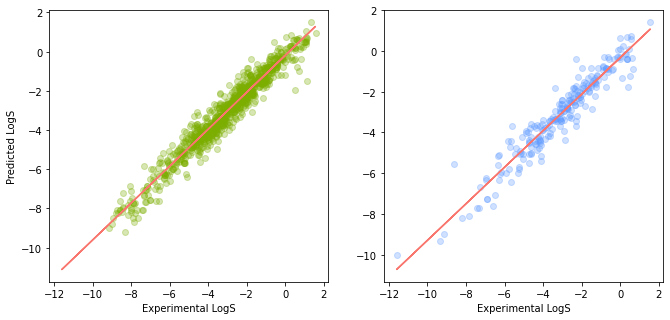

In [83]:
## The first step is to select descriptors

# These are all the descriptors that we calculated
descriptors = ['num_of_atoms', 'num_of_heavy_atoms',
       'num_of_C_atoms', 'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms',
       'tpsa', 'mol_w', 'num_valence_electrons', 'num_heteroatoms',
       'num_aromatic_atoms', 'aromatic_proportion', 'max_abs_partial_charge',
       'min_abs_partial_charge', 'log_p', 'num_rotatable_bonds']

# These three descriptors were used in the Nantasenamat blog post
# descriptors = ['log_p', 'num_rotatable_bonds', 'aromatic_proportion']

## Now we will select the data that we use for training and testing

X = dat['Delaney'][descriptors]
Y = dat['Delaney']['measured log(solubility:mol/L)']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2)

# X_test = X
# Y_test = Y

# to_keep = ~np.isnan(dat['Goodman_training']['S0 (μM)'])
# X_train = dat['Goodman_training'][to_keep][descriptors]
# Y_train = np.log10(dat['Goodman_training'][to_keep]['S0 (μM)']*1E-6)

## This code will preprocess the descriptors

from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

## Now we will define the model. Here I have code for a 
# linear model 
# and a multilayer perceptron neural network.

# from sklearn import linear_model
# model = linear_model.LinearRegression()
# model.fit(X_train, Y_train)
# print('Coefficients:', model.coef_)
# print('Intercept:', model.intercept_)

from sklearn.neural_network import MLPRegressor
model = MLPRegressor(random_state=1, max_iter=500).fit(X_train, Y_train)

## This code compares predicted and measured values in the training and test sets
assess_model(model, X_train, X_test, Y_train, Y_test)

#### --> Develop the model using three descriptors and linear regression. Repeat the calculation at least three times and record the MSE and R^2 for the testing set. How much do these metrics depend on the train-test split?

#### --> Develop the model using all of the descriptors (instead of only 3). How are the MSE and R^2 affected?

#### --> Develop the model using the multilayer perceptron (instead of linear regression). How are the MSE and R^2 affected?

#### --> Copy the code from your best model training above and paste it below. Modify it to train with the Goodman dataset and test on the Delaney dataset. How does your result compare with using subsets of the Delaney dataset?

#### --> Copy the code from your best model training above and paste it below. Modify it to train with the Deleney dataset and test on the Goodman dataset. How does your result compare with using subsets of the Delaney dataset?

Resources
* [Tutorial ML In Chemistry Research. RDkit & mol2vec](https://www.kaggle.com/code/vladislavkisin/tutorial-ml-in-chemistry-research-rdkit-mol2vec/notebook).
* [How to Use Machine Learning for Drug Discovery](https://towardsdatascience.com/how-to-use-machine-learning-for-drug-discovery-1ccb5fdf81ad).